# Machine Learning for Goal Prediction: Distance, Angle, and Shot Type

In [45]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

## Data

In [46]:
df = pd.read_csv('shots_2023_data.csv')
df.head()

,goal,shotDistance,shotType,xCord,yCord,shotAngle
0,0,39.698866,WRIST,59,-26,-40.914383
1,0,11.313709,TIP,81,8,45.000000
2,0,45.343136,SNAP,55,30,41.423666
3,0,43.139309,WRIST,58,-30,-44.060809
4,0,42.201896,WRIST,-64,34,-53.673174


In the dataframe:
- goal is given a 1 if the shot resulted in a goal and 0 otherwise.
- shotDistance is the distance from the net of the shot in feet, where net is defined as being at the (89,0) coordinates.
- shotType is the type of shot (ex Slap, Wrist).
- xCord is the The X coordinate "North South" on the ice of the shot, where  -89 and 89 are the goal lines at each ends of the rink.
- yCord is the Y coordinate "East West" on the ice of the shot. The middle of the ice has a y-coordinate of 0.
- shotAngle is the angle of the shot in degrees. It is a positive number if the shot is from the left side of the ice and negative otherwise.

## Visualizing Data

First, I will visualize the data using a heatmap, which is a data visualization tool used to represent the magnitude of values across a two-dimensional space with varying colors. The heatmap below is displaying the locations of shots on the ice, highlighting both the frequency and type of shots taken. Areas of higher shot concentrations are darker in colour, while lower shot concentrations are lighter in colour. The goal locations are marked in red, allowing us to see where shots are aimed relative to the goal.

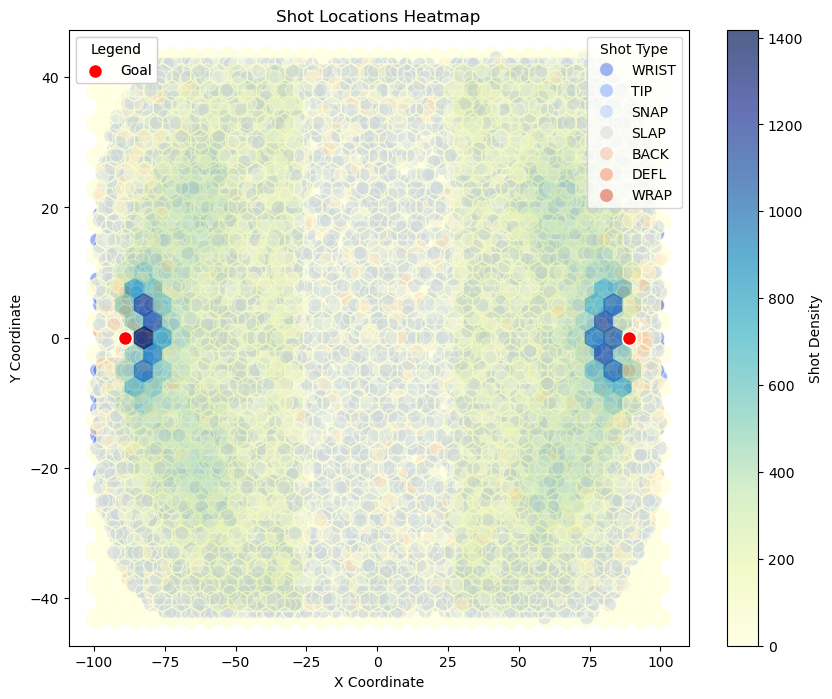

In [47]:
plt.figure(figsize=(10, 8))

goal_x, goal_y = 89, 0  # Center of the goal line
goal_x1, goal_y1 = -89, 0  # Center of the goal line
plt.scatter(goal_x, goal_y, color='red', s=100, edgecolor='white', zorder=3)
plt.scatter(goal_x1, goal_y1, color='red', s=100, edgecolor='white', zorder=3)

sns.scatterplot(x=df['xCord'], y=df['yCord'], hue=df['shotType'], palette='coolwarm', s=100, alpha=0.6)

# Add a legend for the heatmap
heatmap_legend = plt.legend(loc='upper right', title='Shot Type', fontsize=10)
plt.gca().add_artist(heatmap_legend)  # Keep the heatmap legend separate

# Add a separate legend for the goals
goal_legend = plt.legend(
    ['Goal'], loc='upper left', title='Legend', fontsize=10, frameon=True, markerscale=1
)
plt.gca().add_artist(goal_legend)


plt.hexbin(df['xCord'], df['yCord'], gridsize=30, cmap='YlGnBu', alpha=0.7)
plt.colorbar(label='Shot Density')

plt.title('Shot Locations Heatmap')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

## Building Regression Model

In [48]:

# replacing null values in the 'shotType' column with a placeholder 
df['shotType'] = df['shotType'].fillna('UNKNOWN')

# assign shot types to numbers
shot_type_mapping = {
    'WRIST': 1,
    'TIP': 2,
    'SNAP': 3,
    'SLAP': 4,
    'BACK': 5,
    'DEFL': 6,
    'WRAP': 7,
    'UNKNOWN': 0,
}

# Apply the mapping to the 'shotType' column
df['shotTypeEncoded'] = df['shotType'].map(shot_type_mapping)

features = ['xCord', 'yCord', 'shotDistance','shotAngle', 'shotTypeEncoded']
X = df[features]
y = df['goal']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features so that larger values don't impact the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing and training the model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predicting the probabilities
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Evaluating the model
accuracy = accuracy_score(y_test, model.predict(X_test_scaled))
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.9284
ROC AUC: 0.6912


## Probability of A Goal Based on Distance

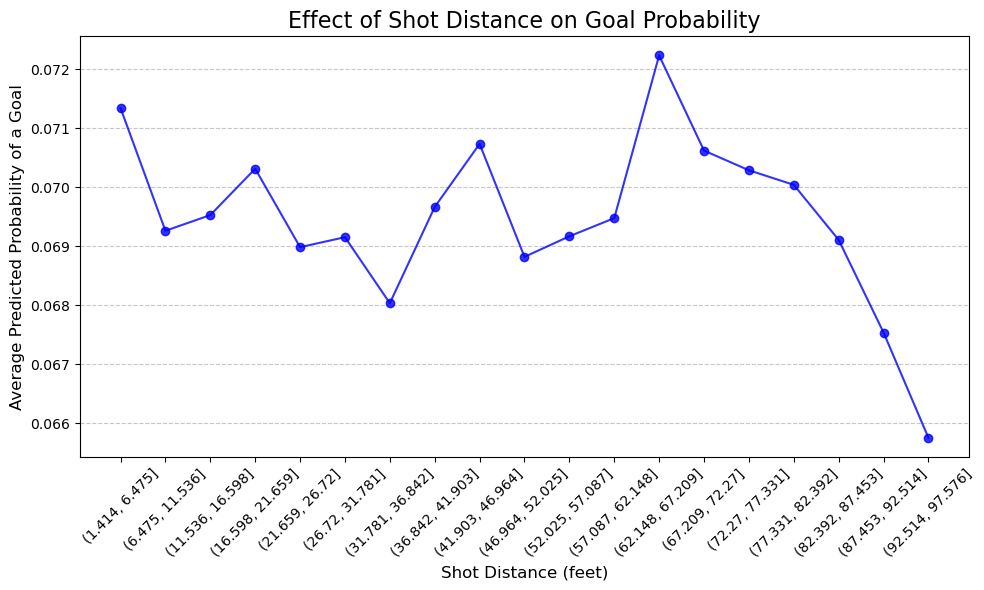

In [49]:

X_test = pd.DataFrame(X_test_scaled, columns=['xCord', 'yCord', 'shotDistance', 'shotAngle', 'shotType'])
X_test['predictedProbability'] = y_prob

X_test['shotDistance'] = df.loc[X_test.index, 'shotDistance']  # Use original shot distance from the dataset
X_test['shotDistanceBin'] = pd.cut(X_test['shotDistance'], bins)

# Create bins based on original shot distance
bins = np.linspace(X_test['shotDistance'].min(), X_test['shotDistance'].max(), 20)

# Check if each bin has enough data
bin_summary = X_test.groupby('shotDistanceBin', observed=True)['predictedProbability'].mean().reset_index()

# Drop NaN or empty bins 
bin_summary = bin_summary.dropna()

# Plotting the relationship between shot distance and predicted probability
plt.figure(figsize=(10, 6))
plt.plot(bin_summary['shotDistanceBin'].astype(str), bin_summary['predictedProbability'], marker='o', color='b', linestyle='-', alpha=0.8)

plt.title("Effect of Shot Distance on Goal Probability", fontsize=16)
plt.xlabel("Shot Distance (feet)", fontsize=12)
plt.ylabel("Average Predicted Probability of a Goal", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Probability of A Goal Based On Shot Angle

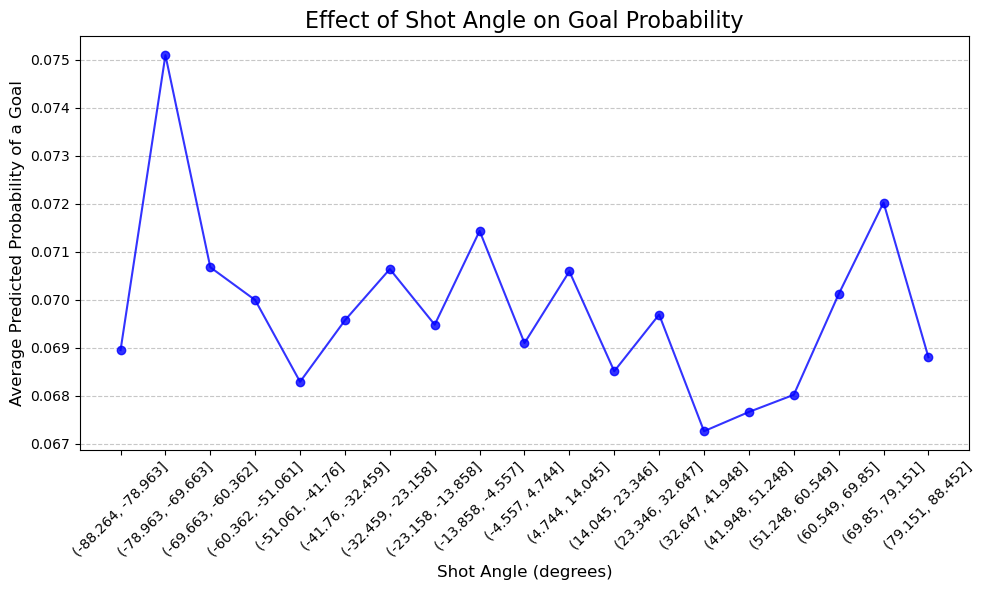

In [50]:

X_test = pd.DataFrame(X_test, columns=['xCord', 'yCord', 'shotDistance', 'shotAngle', 'shotType'])
X_test['predictedProbability'] = y_prob

X_test['shotAngle'] = df.loc[X_test.index, 'shotAngle']  # Use unscaled shot angle from the original dataset

angle_bins = np.linspace(X_test['shotAngle'].min(), X_test['shotAngle'].max(), 20)  # 20 bins for shot angle
X_test['shotAngleBin'] = pd.cut(X_test['shotAngle'], angle_bins)

# Check if each bin has enough data
bin_summary = X_test.groupby('shotAngleBin', observed=True)['predictedProbability'].mean().reset_index()

# Drop NaN or empty bins
bin_summary = bin_summary.dropna()

# Plotting the relationship between shot angle and predicted probability
plt.figure(figsize=(10, 6))
plt.plot(bin_summary['shotAngleBin'].astype(str), bin_summary['predictedProbability'], marker='o', color='b', linestyle='-', alpha=0.8)

plt.title("Effect of Shot Angle on Goal Probability", fontsize=16)
plt.xlabel("Shot Angle (degrees)", fontsize=12)
plt.ylabel("Average Predicted Probability of a Goal", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Probability of A Goal Based on Shot Type

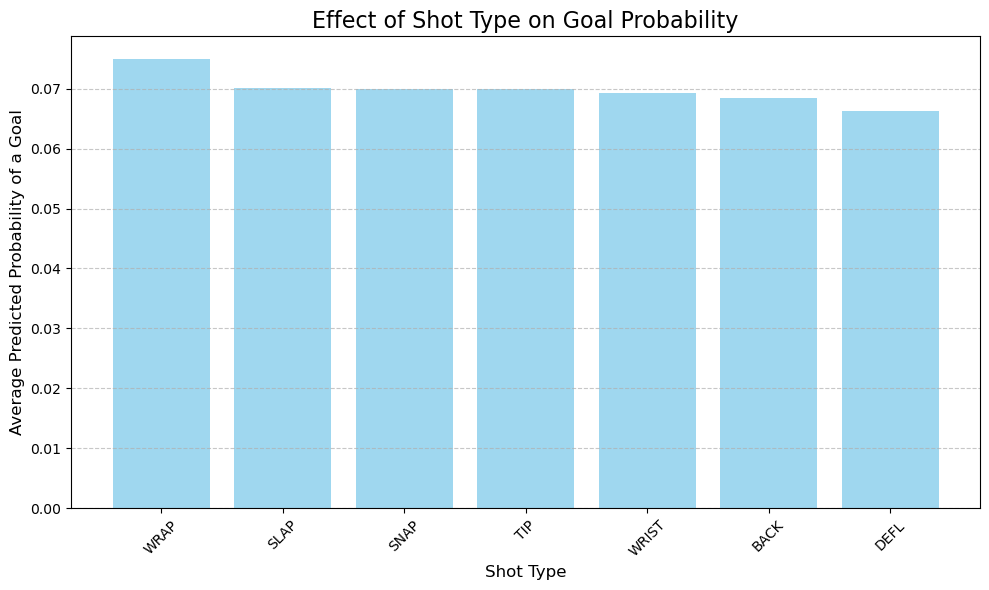

In [51]:
# Adding shotType to X_test for grouping
X_test['shotType'] = df.loc[X_test.index, 'shotType']

# Adding predicted probabilities to X_test
X_test['predictedProbability'] = model.predict_proba(X_test_scaled)[:, 1]

# Group data by shot type and calculate mean predicted probability
bin_summary = (
    X_test.groupby('shotType', observed=True)['predictedProbability']
    .mean()
    .reset_index()
)

# Removing the 'UNKNOWN' shot type from the summary
bin_summary = bin_summary[bin_summary['shotType'] != 'UNKNOWN']

# Sorting by predicted probability for better visualization
bin_summary = bin_summary.sort_values('predictedProbability', ascending=False)

# Plotting the relationship between shot type and predicted probability
plt.figure(figsize=(10, 6))
plt.bar(bin_summary['shotType'], bin_summary['predictedProbability'], color='skyblue', alpha=0.8)

plt.title("Effect of Shot Type on Goal Probability", fontsize=16)
plt.xlabel("Shot Type", fontsize=12)
plt.ylabel("Average Predicted Probability of a Goal", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
